In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data\AAPM21'
folder = r'Radiographs\Two\resolution_piece_40kVp_analyzed'
subfolders = ['large', 'middle', 'small_1']

contrast_vals = np.zeros(3)
air_std = np.zeros(3)
plastic_std = np.zeros(3)

std_vals = np.zeros((6, 5))

for i, sf in enumerate(subfolders):
    masks = np.load(os.path.join(directory, folder, sf, 'mtf_masks.npy'))
    data = np.load(os.path.join(directory, folder, sf, 'Data', 'data_corr.npy'))[:, :, 6]

    c_vals = np.load(os.path.join(directory, folder, sf, 'mtf_contrast_vals.npz'))
    # c_vals = c_vals.item()
    contrast_vals[i] = c_vals['contrast']
    plastic_std[i] = c_vals['std_1']
    air_std[i] = c_vals['std_2']

    for j in range(2):
        if i == 0:
            r = 2
        else:
            r = 2
        std_vals[2*i+j, 0] = np.nanstd(data*masks[j])
        std_vals[2*i+j, 1] = np.nanstd(data*np.roll(masks[j], r, axis=0))
        std_vals[2*i+j, 2] = np.nanstd(data*np.roll(masks[j], -r, axis=0))
        std_vals[2*i+j, 3] = np.nanstd(data*np.roll(masks[j], r, axis=1))
        std_vals[2*i+j, 4] = np.nanstd(data*np.roll(masks[j], -r, axis=1))

contrast_vals = np.mean(contrast_vals)
air_std = np.mean(air_std)
plastic_std = np.mean(plastic_std)

In [55]:
bar_size = np.array([1, 0.75, 0.66, 0.5, 0.33, 0.25])  # [mm] spot sizes for CT resolution phantom

# calculate the frequency in line pairs per mm or use the known freq
freq = 1 / (2 * bar_size)

mtf_final = []
for i in range(5):
    # M' is the measured noise (STD) in each of the bar patterns, uncorrected
    M_prime = std_vals[:, i]

    # squared noise using ROIs of air and plastic
    # N^2 = (Np^2+Nw^2)/2
    noise_2 = (air_std ** 2 + plastic_std ** 2) / 2
    # correct std of bar patterns for noise using the water ROI, M = sqrt(M'^2-N^2)
    M = []
    for std in M_prime:
        if std ** 2 > noise_2:
            M.append(np.sqrt(std ** 2 - noise_2))
        else:
            M.append(0)

    # M = np.array([np.sqrt(std_16**2-noise_2),np.sqrt(std_13**2-noise_2),np.sqrt(std_10**2-noise_2),
    #             np.sqrt(std_08**2-noise_2),np.sqrt(std_06**2-noise_2),np.sqrt(std_05**2-noise_2)])

    # M0 = (CT1-CT2)/2: |Air - Plastic|/2
    M0 = contrast_vals / 2

    # MTF = (pi*sqrt(2)/4)*(M/M0)
    MTF = (np.pi * np.sqrt(2) / 4) * (M / M0)
    mtf_final.append(MTF)

mtf_final = np.array(mtf_final)

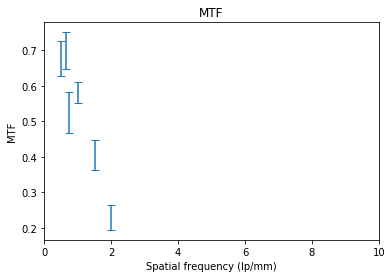

In [56]:
mtf_mean = np.mean(mtf_final, axis=0)
mtf_std = np.std(mtf_final, axis=0)

fig = plt.figure()
plt.errorbar(freq, mtf_mean, yerr=mtf_std, fmt='none', capsize=4)
plt.title("MTF")
plt.ylabel("MTF")
plt.xlabel("Spatial frequency (lp/mm)")
plt.xlim([0, 10])
plt.show()

# Save the MTF
np.save(os.path.join(directory, folder, 'mtf.npy'), np.array([freq, mtf_mean, mtf_std*2]))


In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data\AAPM21\Radiographs\Two'
folder = r'Stationary_MV_analyzed\phantom_scan'

masks = np.load(os.path.join(directory, folder, 'mtf_masks.npy'))
data = np.load(os.path.join(directory, folder, 'Data', 'data_corr.npy'))[:, :, 6]

c_vals = np.load(os.path.join(directory, folder, 'mtf_contrast_vals.npz'))

std_vals = np.zeros((4, 3))
for i in range(4):
    std_vals[i, 0] = np.nanstd(data*masks[i])
    for j, j_val in enumerate([-1, 1]):
        std_vals[i, j+1] = np.nanstd(data*np.roll(masks[i], j_val, axis=0))


contrast_vals = c_vals['contrast']
plastic_std = c_vals['std_1']
air_std = c_vals['std_2']

In [58]:
freq = [0.2, 0.25, 0.45, 0.76]  # MV PipsPro

mtf_final = []
for i in range(3):
    # M' is the measured noise (STD) in each of the bar patterns, uncorrected
    M_prime = std_vals[:, i]

    # squared noise using ROIs of air and plastic
    # N^2 = (Np^2+Nw^2)/2
    noise_2 = (air_std ** 2 + plastic_std ** 2) / 2
    # correct std of bar patterns for noise using the water ROI, M = sqrt(M'^2-N^2)
    M = []
    for std in M_prime:
        if std ** 2 > noise_2:
            M.append(np.sqrt(std ** 2 - noise_2))
        else:
            M.append(0)

    # M = np.array([np.sqrt(std_16**2-noise_2),np.sqrt(std_13**2-noise_2),np.sqrt(std_10**2-noise_2),
    #             np.sqrt(std_08**2-noise_2),np.sqrt(std_06**2-noise_2),np.sqrt(std_05**2-noise_2)])

    # M0 = (CT1-CT2)/2: |Air - Plastic|/2
    M0 = contrast_vals / 2

    # MTF = (pi*sqrt(2)/4)*(M/M0)
    MTF = (np.pi * np.sqrt(2) / 4) * (M / M0)
    mtf_final.append(MTF)

mtf_final = np.array(mtf_final)

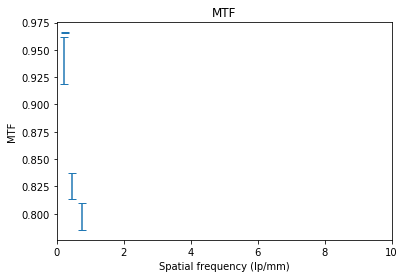

In [59]:
mtf_mean = np.mean(mtf_final, axis=0)
mtf_std = np.std(mtf_final, axis=0)

fig = plt.figure()
plt.errorbar(freq, mtf_mean, yerr=mtf_std, fmt='none', capsize=4)
plt.title("MTF")
plt.ylabel("MTF")
plt.xlabel("Spatial frequency (lp/mm)")
plt.xlim([0, 10])
plt.show()

# Save the MTF
np.save(os.path.join(directory, folder, 'mtf.npy'), np.array([freq, mtf_mean, 2*mtf_std]))

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data\AAPM21\Radiographs\Two'
folder = r'Stationary_kV_analyzed\phantom_scan'

masks = np.load(os.path.join(directory, folder, 'mtf_masks.npy'))
data = np.load(os.path.join(directory, folder, 'Data', 'data_corr.npy'))[:, :, 6]

c_vals = np.load(os.path.join(directory, folder, 'mtf_contrast_vals.npz'))

std_vals = np.zeros((3, 5))
for i in range(3):
    std_vals[i, 0] = np.nanstd(data*masks[i])
    for j, j_val in enumerate([-2, -1, 1, 2]):
        std_vals[i, j+1] = np.nanstd(data*np.roll(masks[i], j_val, axis=0))


contrast_vals = c_vals['contrast']
plastic_std = c_vals['std_1']
air_std = c_vals['std_2']

In [61]:
freq = [0.66, 0.98, 1.50]  # kV PipsPro

mtf_final = []
for i in range(5):
    # M' is the measured noise (STD) in each of the bar patterns, uncorrected
    M_prime = std_vals[:, i]

    # squared noise using ROIs of air and plastic
    # N^2 = (Np^2+Nw^2)/2
    noise_2 = (air_std ** 2 + plastic_std ** 2) / 2
    # correct std of bar patterns for noise using the water ROI, M = sqrt(M'^2-N^2)
    M = []
    for std in M_prime:
        if std ** 2 > noise_2:
            M.append(np.sqrt(std ** 2 - noise_2))
        else:
            M.append(0)

    # M = np.array([np.sqrt(std_16**2-noise_2),np.sqrt(std_13**2-noise_2),np.sqrt(std_10**2-noise_2),
    #             np.sqrt(std_08**2-noise_2),np.sqrt(std_06**2-noise_2),np.sqrt(std_05**2-noise_2)])

    # M0 = (CT1-CT2)/2: |Air - Plastic|/2
    M0 = contrast_vals / 2

    # MTF = (pi*sqrt(2)/4)*(M/M0)
    MTF = (np.pi * np.sqrt(2) / 4) * (M / M0)
    mtf_final.append(MTF)

mtf_final = np.array(mtf_final)

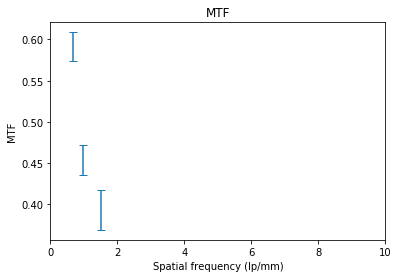

In [62]:
mtf_mean = np.mean(mtf_final, axis=0)
mtf_std = np.std(mtf_final, axis=0)

fig = plt.figure()
plt.errorbar(freq, mtf_mean, yerr=mtf_std, fmt='none', capsize=4)
plt.title("MTF")
plt.ylabel("MTF")
plt.xlabel("Spatial frequency (lp/mm)")
plt.xlim([0, 10])
plt.show()

# Save the MTF
np.save(os.path.join(directory, folder, 'mtf.npy'), np.array([freq, mtf_mean, 2*mtf_std]))